<a href="https://colab.research.google.com/github/Masterjun12/Pytorch-tutorials-/blob/main/pytorch_u_net_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code : https://notitleuntitle.github.io/coding/02-pytorch-UNet/

In [3]:
import os
import sys
print(os.getcwd())
!ls

/content
drive  sample_data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
  project_path = '/content/drive/MyDrive/PyTorch'
sys.path.insert(0, project_path)

In [6]:
# # For download pascal voc 2007 dataset
from torchvision.datasets import VOCSegmentation
VOCSegmentation(root=os.path.join(project_path, 'data'), year='2007', download=True)

100%|██████████| 460032000/460032000 [00:22<00:00, 20343014.12it/s]


Extracting /content/drive/MyDrive/PyTorch/data/VOCtrainval_06-Nov-2007.tar to /content/drive/MyDrive/PyTorch/data


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: /content/drive/MyDrive/PyTorch/data

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [8]:
import os
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image

class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir=os.path.join(project_path,'data/VOCdevkit/VOC2007'), txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.filenames)

In [12]:
transform = A.Compose([
    A.Resize(512, 512),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

dataset = DatasetFromFolderVOC(transforms=transform)
img, gt = dataset[0]
pallete = dataset.pallete

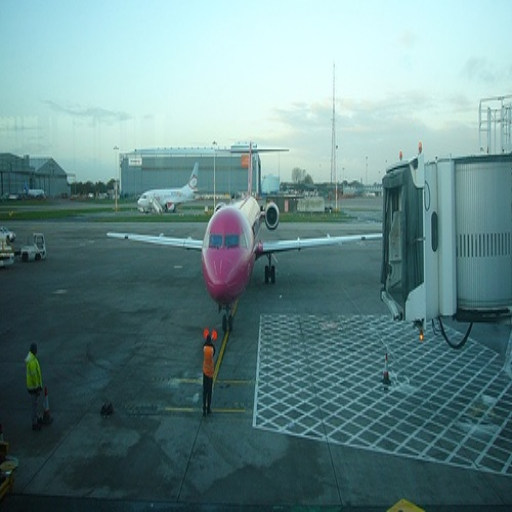

In [13]:
tf = transforms.ToPILImage()
tf(img)

In [14]:
gt_img = tf(gt)
gt_img.putpalette(dataset.pallete)

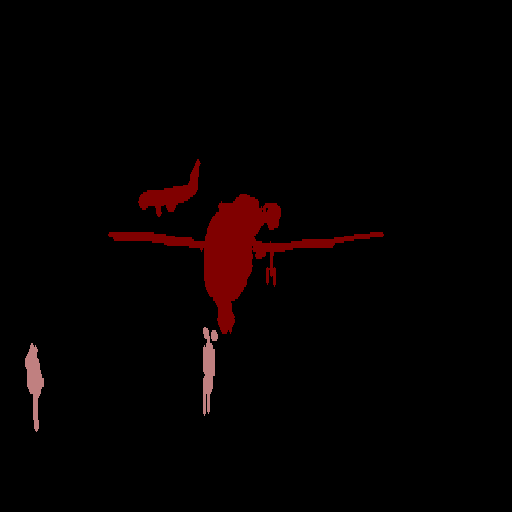

In [15]:
gt_img

In [16]:
from torch.utils.data import DataLoader

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_set = DatasetFromFolderVOC(txt_file='train.txt', transforms=transform)
test_set = DatasetFromFolderVOC(txt_file='val.txt', transforms=transform)

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
trainDataLoader = DataLoader(dataset=train_set, num_workers=2, batch_size=8, shuffle=True)
testDataLoader = DataLoader(dataset=test_set, num_workers=1, batch_size=1, shuffle=False)

In [17]:

class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    # Class initialization 인자를 확인해 보세요
    def __init__(self, in_channels, out_channels, mid_channels= -11):
        super(ConvBlock, self).__init__()
        if mid_channels == -11:
          mid_channels = out_channels
        self.conv1 =  nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.batchnor1 = nn.BatchNorm2d(mid_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.batchnor2 = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.batchnor1(out))

        out = self.conv2(out)
        out = F.relu(self.batchnor2(out))

        return out


# input_tensor = torch.LongTensor([1,2,3], [64])
# debug = ConvBlock(input_tensor)
# print("Input shape:", input_tensor.shape)
# print("Output shape:", debug.shape)
# print("Example features:\n", embed_vectors[:,:,:2])
# debug = ConvBlock()
# torch.Tensor(2,3,64,64)

In [19]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )


    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

In [20]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
      super(Up, self).__init__()
      self.up = nn.Upsample(scale_factor=2, mode='bilinear')
      self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)



    def forward(self, x1, x2):
      x1 = self.up(x1)
      x = torch.cat([x2, x1], dim=1)
      x = self.conv(x)
      return x

In [21]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)



    def forward(self, x):
      x = self.conv(x)
      return x

In [22]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
      super(UNet, self).__init__()
      # self.n_channels = n_channels
      # self.n_classes = n_classes

      self.one = ConvBlock(n_channels, 64)
      self.two = Down(64, 128)
      self.three = Down(128, 256)
      self.four = Down(256, 512)
      self.five = Down(512, 512)
      self.six = Up(1024, 256)
      self.seven = Up(512, 128)
      self.eight = Up(256, 64)
      self.nine = Up(128, 64)
      self.out = OutConv(64, n_classes)


    def forward(self, x):
      # x = x.permute(0,3,1,2)
      x1 = self.one(x)
      x2 = self.two(x1)
      x3 = self.three(x2)
      x4 = self.four(x3)
      x5 = self.five(x4)
      x = self.six(x5, x4)
      x = self.seven(x, x3)
      x = self.eight(x, x2)
      x = self.nine(x, x1)
      logits = self.out(x)
      return logits

In [23]:
num_classes = 21  # 20 + background
model = UNet(3, num_classes).cuda()
model = model.train()
criterion = nn.CrossEntropyLoss()

In [24]:
# VOC_CLASSES = [
#     "background",
#     "aeroplane",
#     "bicycle",
#     "bird",
#     "boat",
#     "bottle",
#     "bus",
#     "car",
#     "cat",
#     "chair",
#     "cow",
#     "diningtable",
#     "dog",
#     "horse",
#     "motorbike",
#     "person",
#     "potted plant",
#     "sheep",
#     "sofa",
#     "train",
#     "tv/monitor",
# ]

In [53]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

total_epoch = 100

for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)
        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'[{epoch+1}][{i+1}/{len(trainDataLoader)}] Loss: {loss.item():.3f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1][1/27] Loss: 2.687
[1][11/27] Loss: 2.021
[1][21/27] Loss: 1.589
[2][1/27] Loss: 1.418
[2][11/27] Loss: 0.896
[2][21/27] Loss: 1.377
[3][1/27] Loss: 1.318
[3][11/27] Loss: 1.109
[3][21/27] Loss: 1.216
[4][1/27] Loss: 1.506
[4][11/27] Loss: 1.461
[4][21/27] Loss: 1.266
[5][1/27] Loss: 1.310
[5][11/27] Loss: 1.443
[5][21/27] Loss: 1.031
[6][1/27] Loss: 1.184
[6][11/27] Loss: 1.405
[6][21/27] Loss: 0.872
[7][1/27] Loss: 0.999
[7][11/27] Loss: 1.076
[7][21/27] Loss: 1.245
[8][1/27] Loss: 1.231
[8][11/27] Loss: 1.068
[8][21/27] Loss: 1.354
[9][1/27] Loss: 0.926
[9][11/27] Loss: 1.295
[9][21/27] Loss: 0.807
[10][1/27] Loss: 0.977
[10][11/27] Loss: 1.231
[10][21/27] Loss: 1.306
[11][1/27] Loss: 1.059
[11][11/27] Loss: 1.014
[11][21/27] Loss: 0.799
[12][1/27] Loss: 1.043
[12][11/27] Loss: 0.775
[12][21/27] Loss: 1.197
[13][1/27] Loss: 0.837
[13][11/27] Loss: 1.216
[13][21/27] Loss: 0.934
[14][1/27] Loss: 1.279
[14][11/27] Loss: 1.296
[14][21/27] Loss: 0.856
[15][1/27] Loss: 1.049
[15][11/27

In [70]:
gt_np = gt.cpu().numpy()
pred_np = pred_classes.cpu().numpy()

In [71]:
print(gt_np.shape)
print(pred_np.shape)

(1, 256, 256)
(1, 256, 256)


In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score

gt_flat = gt_np.flatten()
pred_flat = pred_np.flatten()

precision = precision_score(gt_flat, pred_flat, average='macro')
recall = recall_score(gt_flat, pred_flat, average='macro')
f1 = f1_score(gt_flat, pred_flat, average='macro')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Precision: 0.051
Recall: 0.014
F1 Score: 0.020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


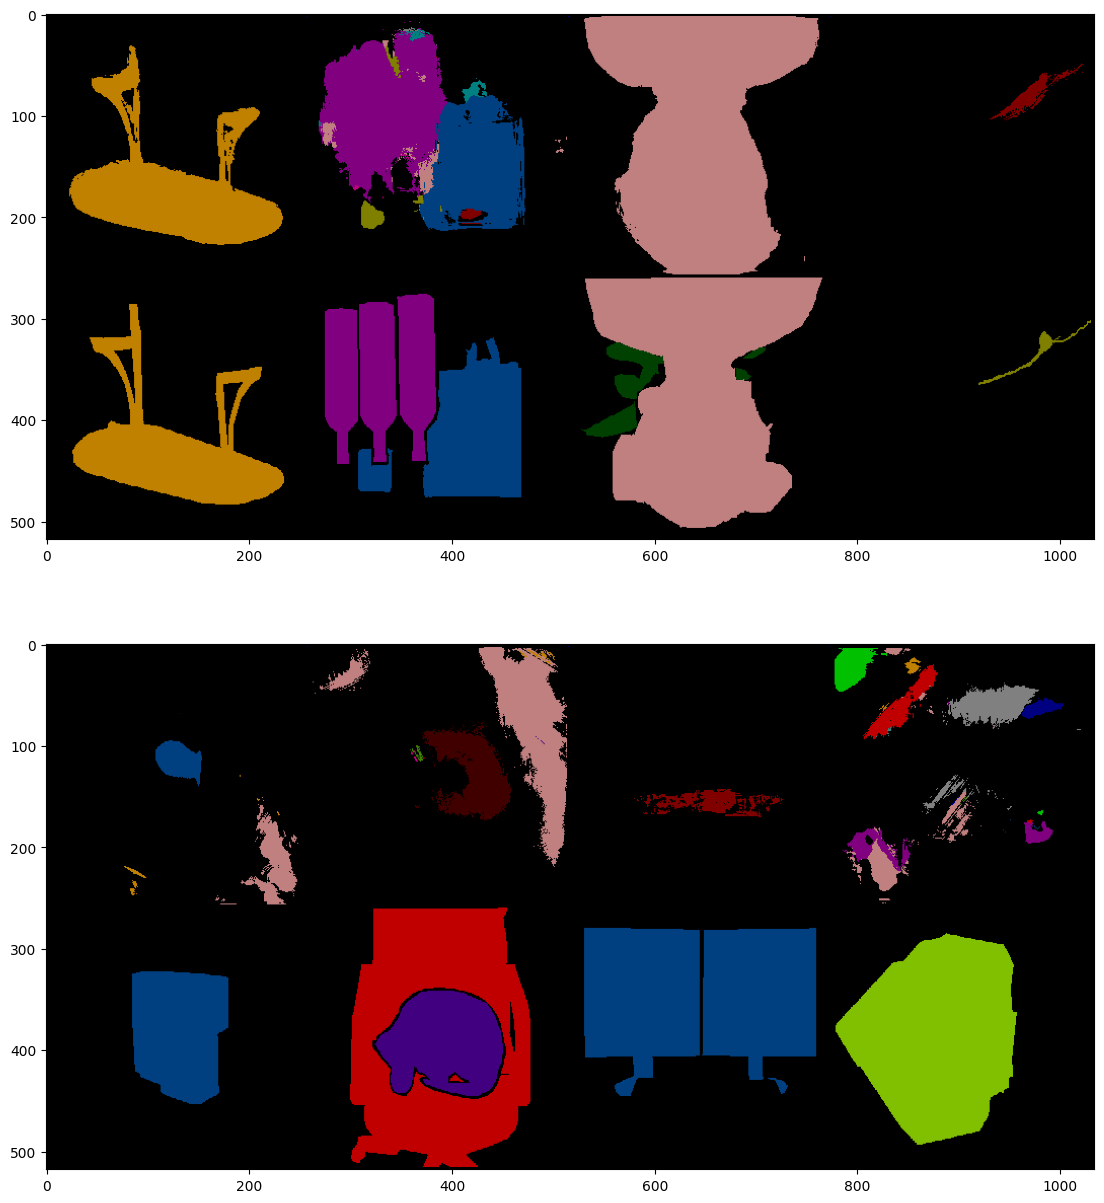

In [64]:
# Visualization
model.eval()
num_imgs = 4
preds_train, gts_train = None, None
preds_val, gts_val = None, None
for i, (img, gt) in enumerate(trainDataLoader):
    if i * trainDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(trainDataLoader.batch_size, 4)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_train = out_img if i == 0 and j == 0 else torch.cat([preds_train, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_train = out_img if i == 0 and j == 0 else torch.cat([gts_train, out_img])

for i, (img, gt) in enumerate(testDataLoader):
    if i * testDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(testDataLoader.batch_size, num_imgs)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_test = out_img if i == 0 and j == 0 else torch.cat([preds_test, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_test = out_img if i == 0 and j == 0 else torch.cat([gts_test, out_img])

train_samples = torch.cat([preds_train.cpu(), gts_train])
train_samples = torchvision.utils.make_grid(train_samples, nrow=num_imgs)
train_samples = train_samples.permute(1, 2, 0)

test_samples = torch.cat([preds_test.cpu(), gts_test])
test_samples = torchvision.utils.make_grid(test_samples, nrow=num_imgs)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplot(2, 1, 1)
plt.imshow(train_samples)
plt.subplot(2, 1, 2)
plt.imshow(test_samples)